In [2]:
import cv2
import time
import numpy as np
from tqdm import tqdm
from IPython.display import display, Image, clear_output

from facelib import FaceDetector, EmotionDetector


In [9]:
# Set the path to your input video
VIDEO_PATH = 'data/input.mp4'

face_detector = FaceDetector()
# face_detector = FaceDetector(name='resnet')
emotion_detector = EmotionDetector()


from EmotionDetector: weights loaded


In [7]:
cap = cv2.VideoCapture(VIDEO_PATH)

if not cap.isOpened():
    print(f"Error: Could not open video {VIDEO_PATH}")


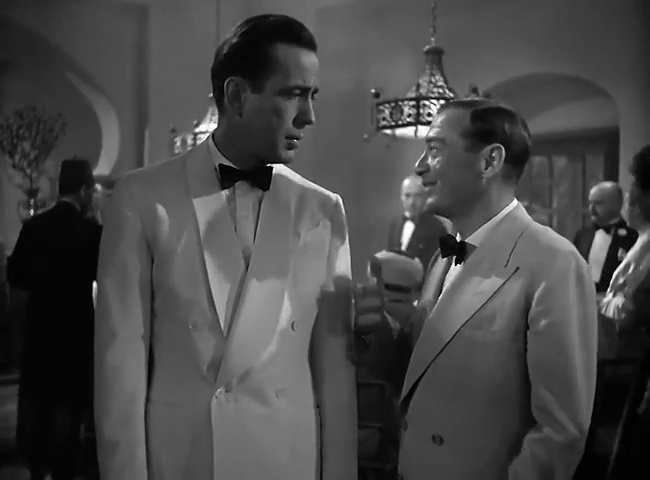

Processing Frames:   3%|▎         | 208/7194 [00:29<16:32,  7.04it/s]


KeyboardInterrupt: 

In [12]:
fps = cap.get(cv2.CAP_PROP_FPS)       # frames per second

offset_min = 10
offset_in_frames = int(offset_min * 60 * fps)
cap.set(cv2.CAP_PROP_POS_FRAMES, offset_in_frames)

# --- PROCESS next 5 minutes of frames ---
frames_to_process = int(5 * 60 * fps)  # 5 minutes = 300 seconds
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Ensure we don't exceed the total number of frames
upper_frame_limit = offset_in_frames + frames_to_process
if upper_frame_limit > total_frames:
    upper_frame_limit = total_frames

print(f"Starting from {offset_min} min, processing up to frame {upper_frame_limit}...")

print(f"Processing up to {frames_to_process} frames (~5 minutes)...")

for frame_idx in tqdm(range(offset_in_frames, upper_frame_limit), desc='Processing Frames'):
    ret, frame = cap.read()
    if not ret:
        print("Error: Could not read frame.")
        break

    # Detect faces
    faces, boxes, scores, landmarks = face_detector.detect_align(frame)

    for det in boxes:
        # Example detection: assume 'box' -> [x1, y1, x2, y2]
        x1, y1, x2, y2 = [int(coord.item()) for coord in det]
        
        # Extract the face region
        face_region = frame[y1:y2, x1:x2]
        
        # Recognize facial expression (happy, sad, angry, etc.)
        emotions, probab = emotion_detector.detect_emotion(faces)
        
        # Draw bounding box
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Show identity and expression
        label = f"{emotions}: {[round(p, 2) for p in probab]}"
        cv2.putText(frame, label, (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    # Convert current frame to JPEG for inline display
    _, encoded_img = cv2.imencode('.jpg', frame)
    
    # Display inline in the notebook
    clear_output(wait=True)
    display(Image(data=encoded_img))

cap.release()
print("Processing complete!")
